## In this notebook I aim to change the noise input of the generator to a low resolution galaxy image instead

By Shooby, started: July 25 <br>
last edited: July 29

In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F


from astropy.convolution import convolve_fft as convolve
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
# initializing parameters:

dataroot='gals/'
device = torch.device("cuda:0") # If GPU then use "cuda:0"
ngpu = 3 #number of GPUs to use 
ngf = 64
ndf = 64
workers = 8 #number of data loading workers
batchSize = 64 #input batch size
imageSize = 64 #the height / width of the input image to network
nz = (imageSize//2)*(imageSize//2) #size of the latent z vector
niter = 100 #number of epochs to train for
lr = 0.0002 #learning rate, default=0.0002
beta1 = 0.5 #beta1 for adam. default=0.5
outf='outputs' #folder to output images and model checkpoints
print(nz)

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


1024
Random Seed:  8204


In [3]:
dataset = dset.MNIST(root=dataroot, download=True,
                     transform=transforms.Compose([transforms.Resize(imageSize),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
nc=1

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))


/home/hnayyeri/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hnayyeri/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([64, 1, 64, 64])
torch.Size([1, 1, 63, 63])
torch.Size([64, 1, 64, 64])


/home/hnayyeri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log10
/home/hnayyeri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


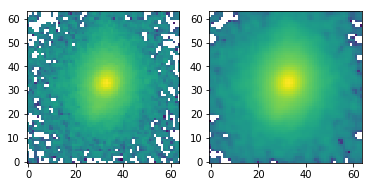

In [4]:

psf = pyfits.getdata('psf_h.fits')
psf = np.asarray(psf[20:-20,20:-20],dtype='d')


psfh = np.repeat(psf[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel = F.upsample(kernel,scale_factor=0.5,mode='bilinear')
kernel =  kernel.float()


test_im = pyfits.getdata('gal_cutout.fits')
test_im = np.asarray(test_im,dtype=float)
data = np.repeat(test_im[:, :, np.newaxis], batchSize, axis=2)
data = np.repeat(data[:,:,:,np.newaxis],1,axis = 3)
data = torch.Tensor(data)
data = data.permute(2,3,0,1)

output = F.conv2d(data, kernel,padding=int(((kernel.shape[3])-1)/2))

print(data.shape)
print(kernel.shape)
print(output.shape)

convolved = output.data.numpy()
im = convolved[1,0,:,:]
plt.subplot(1,2,1)
plt.imshow(np.log10(test_im),origin='lower')
plt.subplot(1,2,2)
plt.imshow(np.log10(im),origin='lower')

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if netD != '':
#    netD.load_state_dict(torch.load(netD))
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake, converting image to a noise array
        kernel = kernel.to(device)
        img = F.conv2d(real_cpu, kernel,padding=int(((kernel.shape[3])-1)/2))
        img = img+0.02*torch.rand_like(img)
        downsampled = F.upsample(img,scale_factor=0.5,mode='bilinear')
        #print(downsampled.shape)
        #stop
        downsampled_1d = downsampled.view([batch_size,nz,1,1])
        
        fake = netG(downsampled_1d)
        label.fill_(fake_label)
        fd = fake.detach()
        output = netD(fd.float())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)
    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/50][0/95] Loss_D: 1.7453 Loss_G: 9.2416 D(x): 0.2436 D(G(z)): 0.1575 / 0.0002
[0/50][1/95] Loss_D: 23.0031 Loss_G: 0.2550 D(x): 1.0000 D(G(z)): 1.0000 / 0.7857
[0/50][2/95] Loss_D: 13.7273 Loss_G: 6.7788 D(x): 1.0000 D(G(z)): 1.0000 / 0.0012
[0/50][3/95] Loss_D: 10.0841 Loss_G: 10.5183 D(x): 1.0000 D(G(z)): 0.9997 / 0.0000
[0/50][4/95] Loss_D: 5.0107 Loss_G: 15.8403 D(x): 1.0000 D(G(z)): 0.9745 / 0.0000
[0/50][5/95] Loss_D: 0.9038 Loss_G: 17.1302 D(x): 0.9999 D(G(z)): 0.5720 / 0.0000
[0/50][6/95] Loss_D: 0.7002 Loss_G: 16.6483 D(x): 0.9996 D(G(z)): 0.4921 / 0.0000
[0/50][7/95] Loss_D: 1.5973 Loss_G: 18.8255 D(x): 0.9847 D(G(z)): 0.7673 / 0.0000
[0/50][8/95] Loss_D: 0.4676 Loss_G: 16.8790 D(x): 0.9999 D(G(z)): 0.3706 / 0.0000
[0/50][9/95] Loss_D: 2.6557 Loss_G: 19.4600 D(x): 0.9822 D(G(z)): 0.8862 / 0.0001
[0/50][10/95] Loss_D: 0.0648 Loss_G: 13.3703 D(x): 0.9998 D(G(z)): 0.0625 / 0.0000
[0/50][11/95] Loss_D: 4.8414 Loss_G: 17.1068 D(x): 0.9967 D(G(z)): 0.9909 / 0.0000
[0/50][12/95] 

# ignore below

In [23]:
noise = torch.randn(batchSize, nz, 1, 1, device=device)
print(noise.shape)
for i, data in enumerate(dataloader, 0):
    
    img =  data[0].to(device)    
    kernel = kernel.to(device)
    img = F.conv2d(img, kernel,padding=int(((kernel.shape[3])-1)/2))
    img = img+0.01*torch.rand_like(img)
    downsampled = F.upsample(img,scale_factor=0.25,mode='bilinear')
    d = downsampled.view([64,256,1,1])
    stop



torch.Size([64, 256, 1, 1])


NameError: name 'stop' is not defined